In XGBoost Model

Make comparison of RMSE estimation for two different set of bins and for dataframe with and without imbued 0s.

***Note: the highly correlated features in dataset without imbued 0s are different(only two features with correlation value greater than 10).***

In [ ]:
%load_ext jupyter_black

In [ ]:
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

from utils import get_clean_dataset

In [ ]:
df = get_clean_dataset()

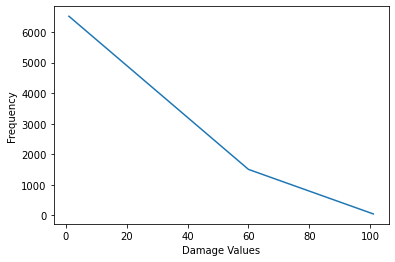

In [34]:
#The Old and New set of bins
bins2= [0, 1, 60, 101]
#bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [35]:
print(samples_per_bin2)
print(binsP2)

[6517 1506   50]
[  0   1  60 101]


In [36]:
#df['DAM_perc_dmg'].value_counts(bins=binsP2)

In [37]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [38]:
y_input_strat=bin_index2

In [39]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 02:01:13


In [40]:
#Define empty lists for bins results(test and train)
test_RMSE_list_bin1=[]
test_RMSE_list_bin2=[]
test_RMSE_list_bin3=[]

train_RMSE_list_bin1=[]
train_RMSE_list_bin2=[]
train_RMSE_list_bin3=[]

#Only if you use bins2 = [0, 0.00009, 1, 10, 50, 101]
#test_RMSE_list_bin4=[]
#test_RMSE_list_bin5=[]

#train_RMSE_list_bin4=[]
#train_RMSE_list_bin5=[]

In [41]:
#Dropping highly correlated features which their correlation values are greater than 0.99.
features =[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA', 
    #'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    #'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary']

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


for i in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)
    
    #XGBoost
    #xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8)
    #xgb_model=xgb.fit(X_train, y_train)
    
    
    #XGBoost Reduced Overfitting
    xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                       colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                       importance_type='gain', learning_rate=0.1, max_delta_step=0,
                       max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                       n_jobs=1, nthread=None, objective='reg:squarederror', 
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"],
                       random_state=0,
                      )


    eval_set = [(X_test, y_test)]
    xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())
    
    bin_index_test=np.digitize(y_test, bins=binsP2)
    bin_index_train=np.digitize(y_train, bins=binsP2)
    
    y_pred_train = xgb.predict(X_train)
    
    mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    rmse_train_3 = np.sqrt(mse_train_idx3)
    
    #Only if you use bins2 = [0, 0.00009, 1, 10, 50, 101]
    #mse_train_idx4 = mean_squared_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
    #rmse_train_4 = np.sqrt(mse_train_idx4)
    #mse_train_idx5 = mean_squared_error(y_train[bin_index_train==5], y_pred_train[bin_index_train==5])
    #rmse_train_5 = np.sqrt(mse_train_idx5)
    


    y_pred = xgb.predict(X_test)
    
    mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    rmse_1 = np.sqrt(mse_idx1)
    mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    rmse_2 = np.sqrt(mse_idx2)
    mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    rmse_3 = np.sqrt(mse_idx3)
    
    #Only if you use bins2 = [0, 0.00009, 1, 10, 50, 101]
    #mse_idx4 = mean_squared_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
    #rmse_4 = np.sqrt(mse_idx4)
    #mse_idx5 = mean_squared_error(y_test[bin_index_test==5], y_pred[bin_index_test==5])
    #rmse_5 = np.sqrt(mse_idx5)
    
    
    train_RMSE_list_bin1.append(rmse_train_1)
    train_RMSE_list_bin2.append(rmse_train_2)
    train_RMSE_list_bin3.append(rmse_train_3)
 
    
    test_RMSE_list_bin1.append(rmse_1)
    test_RMSE_list_bin2.append(rmse_2)
    test_RMSE_list_bin3.append(rmse_3) 
    
    #Only if you use bins2 = [0, 0.00009, 1, 10, 50, 101]
    #train_RMSE_list_bin4.append(rmse_train_4)
    #train_RMSE_list_bin5.append(rmse_train_5)
    
    #test_RMSE_list_bin4.append(rmse_4)   
    #test_RMSE_list_bin5.append(rmse_5)
    

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     180.9
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:15   Log-Likelihood:                -21472.
No. Observations:                6458   AIC:                         4.301e+04
Df Residuals:                    6426   BIC:                         4.323e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4130      0.084     28.748      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     173.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:16   Log-Likelihood:                -21615.
No. Observations:                6458   AIC:                         4.329e+04
Df Residuals:                    6426   BIC:                         4.351e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4803      0.086     28.905      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     203.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:17   Log-Likelihood:                -21218.
No. Observations:                6458   AIC:                         4.250e+04
Df Residuals:                    6426   BIC:                         4.272e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3835      0.081     29.532      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     188.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:19   Log-Likelihood:                -21470.
No. Observations:                6458   AIC:                         4.300e+04
Df Residuals:                    6426   BIC:                         4.322e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4966      0.084     29.752      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     192.6
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:20   Log-Likelihood:                -21422.
No. Observations:                6458   AIC:                         4.291e+04
Df Residuals:                    6426   BIC:                         4.313e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4131      0.083     28.971      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     185.7
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:21   Log-Likelihood:                -21453.
No. Observations:                6458   AIC:                         4.297e+04
Df Residuals:                    6426   BIC:                         4.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4473      0.084     29.237      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     176.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:23   Log-Likelihood:                -21527.
No. Observations:                6458   AIC:                         4.312e+04
Df Residuals:                    6426   BIC:                         4.333e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4313      0.085     28.726      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     176.7
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:24   Log-Likelihood:                -21536.
No. Observations:                6458   AIC:                         4.314e+04
Df Residuals:                    6426   BIC:                         4.335e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5114      0.085     29.625      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     178.7
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:25   Log-Likelihood:                -21554.
No. Observations:                6458   AIC:                         4.317e+04
Df Residuals:                    6426   BIC:                         4.339e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4423      0.085     28.729      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     172.0
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        02:01:27   Log-Likelihood:                -21522.
No. Observations:                6458   AIC:                         4.311e+04
Df Residuals:                    6426   BIC:                         4.333e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4092      0.085     28.483      0.0

In [46]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 02:02:04


stdev_RMSE_test: 0.32
stdev_RMSE_train: 0.04
mean_RMSE_test: 1.68
mean_RMSE_train: 1.37


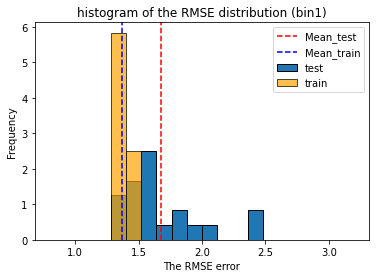

In [47]:
#RMSE of bins_1

m_test_rmse = statistics.mean(test_RMSE_list_bin1)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin1, bins=np.arange(0.8,3.2,0.12), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin1)


m_train_rmse = statistics.mean(train_RMSE_list_bin1)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin1, bins=np.arange(0.8,3.2,0.12), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(0.8,2.9,0.12)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin1)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin1)')
plt.show()

stdev_RMSE_test: 0.87
stdev_RMSE_train: 0.32
mean_RMSE_test: 10.05
mean_RMSE_train: 8.56


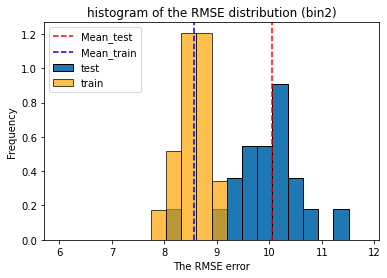

In [48]:
#RMSE of bins_2

m_test_rmse = statistics.mean(test_RMSE_list_bin2)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin2, bins=np.arange(6.0,12.0,0.29), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin2)


m_train_rmse = statistics.mean(train_RMSE_list_bin2)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin2, bins=np.arange(6.0,12.0,0.29), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin2)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin2)')
plt.show()

stdev_RMSE_test: 7.71
stdev_RMSE_train: 3.54
mean_RMSE_test: 45.36
mean_RMSE_train: 33.71


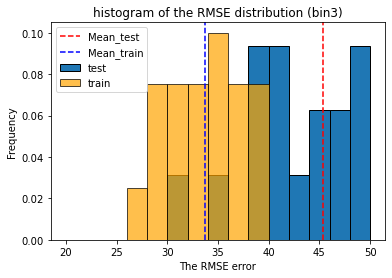

In [51]:
#RMSE of bins_3

m_test_rmse = statistics.mean(test_RMSE_list_bin3)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin3, bins=np.arange(20.0,52.0,2.0), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin3)


m_train_rmse = statistics.mean(train_RMSE_list_bin3)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin3, bins=np.arange(20.0,52.0,2.0), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin3)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin3)')
plt.show()

###***The next cell could run only if you use bins2 = [0, 0.00009, 1, 10, 50, 101]***

In [ ]:
#RMSE of bins_4

m_test_rmse = statistics.mean(test_RMSE_list_bin4)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin4, bins=np.arange(2.0,50.0,2.2), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin4)


m_train_rmse = statistics.mean(train_RMSE_list_bin4)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin4, bins=np.arange(2.0,50.0,2.2), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin4)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin4)')
plt.show()


#RMSE of bins_5

m_test_rmse = statistics.mean(test_RMSE_list_bin5)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin5, bins=np.arange(2.0,50.0,2.2), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin5)


m_train_rmse = statistics.mean(train_RMSE_list_bin5)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin5, bins=np.arange(2.0,50.0,2.2), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin5)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin4)')
plt.show()